<p style="font-size:3em">Classify marketplace's goods</p>

<br/>

This notebook corresponds to the third part of the **6th project of my data scientist path** with **OpenClassrooms/CentralSupelec** 

This project aims to provide the necessary skills to work on NLP and Image classification problems

This thrid notebook contains models using both NLP and Image classification :<br>

* Reload Models
* Model with both NLP and Image features merged together
* Stacking model attempt
                 
___ 
<b>I strongly recommend to use the 'table of content' extension of Jupyter to navigate through this notebook </b>

# Import

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import cv2
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn import metrics, cluster, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,plot_confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin,BaseEstimator

from keras.applications.vgg16 import VGG16
from keras.layers import Dense


from sklearn.manifold import TSNE


from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

import nltk
from gensim.models import doc2vec
import re

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA,SparsePCA

from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import model_from_json
from keras.models import Model


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Model Selected 

## NLP Part

### Preprocessing function 

Here is the list of actions performed by this function:
   * lowercase all documents
   * transform all string documents into a list of tokens (via RegExpression => only keep letters and numbers) 
   * remove the given stop_words from each list of tokens 
   * porter stemming or double wordnetlematization (on Nouns and Verbs) according to the parameters choice 
   
   
Parameters :
   * corpus : list or serie of differents string documents
   * sw_to_use : list of stop_words to be dropped
   * stem_or_lemm : 0 or 1 => 0 To perform lemmatization, 1 to perform stemming
   * display_steps : 0 or 1 => 0 no prints for each steps, 1 print the first document transformation after each action

In [5]:
def nlp_preprocessing(corpus,sw_to_use,stem_or_lemm,display_steps):
    
    if display_steps == 1 : 
        print('NLP Pre-processing : Begin\n_____________________________')

        print('\n________________\nOrignal Shape\n________________\n')
        print(corpus[0])

        print('\n________________\nLower Case\n________________\n')
        preprocessed_text = corpus.str.lower().tolist()
        print(preprocessed_text[0])

        print('\n________________\nTokenizer\n________________\n')
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        preprocessed_text=[tokenizer.tokenize(x) for x in preprocessed_text]
        print(preprocessed_text[0])

        print('\n________________\nStop_Words\n________________\n')
        for i in range(len(preprocessed_text)):
            preprocessed_text[i] = [x for x in preprocessed_text[i] if x not in list(sw_to_use)] 
        print(preprocessed_text[0])

        if stem_or_lemm == 0:
            print('\n________________\nLemmatizer\n________________\n')
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok) for tok in preprocessed_text[i]]
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok,pos='v') for tok in preprocessed_text[i]]
            print(preprocessed_text[0])

        else:
            print('\n________________\nStemmer\n________________\n')
            porter=nltk.stem.PorterStemmer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[porter.stem(tok) for tok in preprocessed_text[i]]
            print(preprocessed_text[0])

        print('\n_____________________________\nNLP Pre-processing : DONE\n_____________________________')
    
    else : 
        preprocessed_text = corpus.str.lower().tolist()
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        preprocessed_text=[tokenizer.tokenize(x) for x in preprocessed_text]
        for i in range(len(preprocessed_text)):
            preprocessed_text[i] = [x for x in preprocessed_text[i] if x not in list(sw_to_use)]      
            
        if stem_or_lemm == 0:
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok) for tok in preprocessed_text[i]]
                preprocessed_text[i]=[wordnet_lemmatizer.lemmatize(tok,pos='v') for tok in preprocessed_text[i]]

        else:
            porter=nltk.stem.PorterStemmer()
            for i in range(len(preprocessed_text)):
                preprocessed_text[i]=[porter.stem(tok) for tok in preprocessed_text[i]]
     
    return preprocessed_text

In [13]:
english_sw = nltk.corpus.stopwords.words('english')

In [14]:
train_doc2vec = nlp_preprocessing(train.description,english_sw,0,0)
test_doc2vec=nlp_preprocessing(test.description,english_sw,0,0)

In [15]:
def corpus_doc2vec(corpus,categories):
    to_return = []
    for i in range(len(corpus)):
        to_return.append(doc2vec.TaggedDocument(train_doc2vec[i], categories[i]))
    
    return to_return

In [16]:
def training_doc2vec(corpus,categories,method):
    train_corpus = corpus_doc2vec(train_doc2vec,categories)
    model = doc2vec.Doc2Vec(dm=method,vector_size=50, min_count=2, epochs=40)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    
    return model

### Model loading (and checking)

In [17]:
model_doc2vec_dbow=training_doc2vec(train_doc2vec,train.category,0)
vector_train_dbow = [model_doc2vec_dbow.infer_vector(x) for x in train_doc2vec]
overview_train_dbow = pd.DataFrame(vector_train_dbow)
vector_test_dbow = [model_doc2vec_dbow.infer_vector(x) for x in test_doc2vec]
overview_test_dbow= pd.DataFrame(vector_test_dbow)

In [20]:
with open('doc2vec_model.pickle', 'rb') as file:
        doc2vec_model=pickle.load(file)

print('\nTest Score (accuracy): ',accuracy_score(test.category,doc2vec_model.predict(overview_test_dbow)))


Test Score (accuracy):  0.919047619047619


In [156]:
with open('word_embedding.pickle', 'rb') as file:
        model_doc2vec_dbow=pickle.load(file)

vector_train_dbow = [model_doc2vec_dbow.infer_vector(x) for x in train_doc2vec]
overview_train_dbow2 = pd.DataFrame(vector_train_dbow)
vector_test_dbow = [model_doc2vec_dbow.infer_vector(x) for x in test_doc2vec]
overview_test_dbow2= pd.DataFrame(vector_test_dbow)

In [157]:
with open('doc2vecmodel2.pickle', 'rb') as file:
        doc2vec_model2=pickle.load(file)

print('\nTest Score (accuracy): ',accuracy_score(test.category,doc2vec_model2.predict(overview_test_dbow2)))


Test Score (accuracy):  0.9095238095238095


In [155]:
overview_test_dbow

,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,...,nlp_40,nlp_41,nlp_42,nlp_43,nlp_44,nlp_45,nlp_46,nlp_47,nlp_48,nlp_49
0,-0.617622,0.551512,-0.183569,-0.753554,0.585995,-0.020980,0.091840,0.349824,-0.166912,0.194164,...,0.346771,0.427655,-0.032480,-0.344968,0.579785,0.425609,-0.560695,-0.387327,-0.303111,-0.282229
1,0.280662,-0.553825,-0.404723,-0.751496,0.237017,-0.128153,-0.828667,0.073621,0.510330,0.378878,...,-0.433610,0.078186,-1.006080,-0.725289,-0.132627,-0.726168,-1.204006,0.485547,-0.538402,0.534379
2,0.003530,1.402174,-0.411422,-0.522085,0.467091,-0.314908,-0.031737,-0.774831,0.456619,-0.222932,...,0.397543,1.073026,0.135431,-0.021826,0.441012,0.111793,0.045807,0.362177,-0.355142,-0.497387
3,-0.238581,0.661713,0.329259,0.171373,0.438907,0.175492,-0.217862,0.553045,0.454607,-0.158184,...,0.046648,0.628112,0.011281,-0.404647,0.796899,0.247272,-0.317878,-0.050072,0.093059,-1.443656
4,0.792692,0.158981,0.391859,-1.080997,-0.399718,0.500170,-0.986777,-0.725341,0.450814,0.479116,...,0.454100,0.695382,0.344440,-0.145002,-1.296809,-0.139817,0.257585,-0.435036,0.492611,-1.494463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,-0.462705,0.373028,-0.022840,-0.716107,0.285513,-0.243926,-0.606405,0.260661,0.198891,-0.463473,...,-0.012910,0.960082,-0.414539,-0.586078,0.802483,0.015420,-0.070373,0.333709,-0.074739,-0.258138
206,-1.154333,0.372837,-0.267419,-1.087434,0.830233,-0.335316,0.302448,0.312928,0.164291,0.761990,...,-0.517518,1.309954,0.660995,-1.413433,-1.319165,-0.841109,-1.092687,-1.469132,0.729160,-0.708190
207,-1.225549,0.455742,0.550579,-0.731575,-0.249683,-0.377728,0.262209,0.637601,0.134660,0.176781,...,0.205094,0.770275,-0.286457,-0.557762,0.322013,0.344819,-0.244902,-0.384269,0.157899,-0.563658
208,0.039167,-1.203789,-0.472034,-1.615267,0.961917,1.144220,-1.197291,1.735326,-0.712229,-0.029643,...,0.555350,1.196482,0.095659,0.060614,-1.440379,0.116213,-1.647581,-0.314994,-0.888512,1.026850


## Image Classification Part

### Load Model + Weights 

In [25]:
# load json and create model
json_file = open('model10.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model10.h5")


In [32]:
loaded_model.summary()

Model: "functional_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

### Preprocess Data

In [23]:
def load_keras(list_of_path):
    
    for i in range(len(list_of_path)):
        if i ==0:
            path = "./Images/" + list_of_path[i]
            img = load_img(path, target_size=(224, 224))  # Charger l'image
            img = img_to_array(img)  # Convertir en tableau numpy
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
            img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
        else: 
            path = "./Images/" + list_of_path[i]
            im = load_img(path, target_size=(224, 224))  # Charger l'image
            im = img_to_array(im)  # Convertir en tableau numpy
            im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))  # Créer la collection d'images (un seul échantillon)
            im = preprocess_input(im)  # Prétraiter l'image comme le veut VGG-16
            img = np.concatenate((img, im), axis=0)
    
    return img

In [29]:
with open('ohe_categ.pickle', 'rb') as file:
        ohe=pickle.load(file)

test_keras = load_keras(test.image)
y_test = ohe.transform(np.array(test.category).reshape(-1,1)).todense()

### Check Model Accuracy 


Test Score (accuracy):  0.8333333333333334
_______________________________________________


Text(0.5, 51.0, 'Predicted Label')

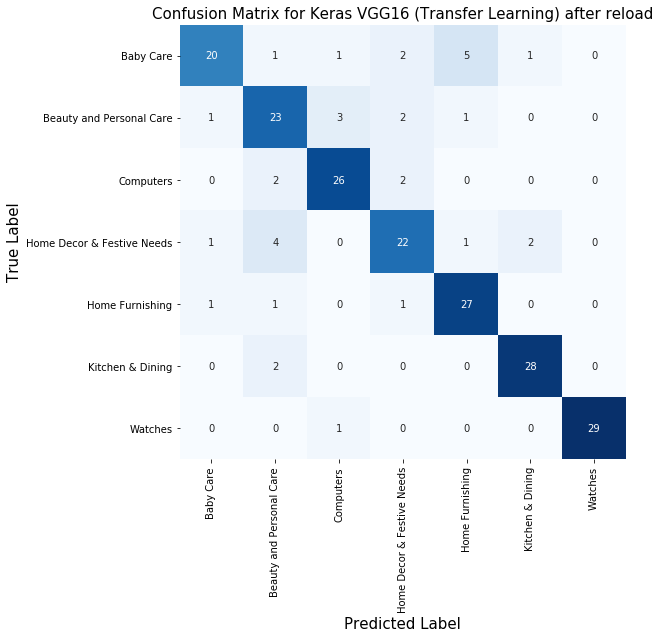

In [30]:
loaded_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

test_keras_pred = loaded_model.predict(test_keras)
print('\nTest Score (accuracy): ',accuracy_score(np.argmax(test_keras_pred, axis=1).reshape(-1,1), 
                                                 np.argmax(y_test, axis=1).reshape(-1,1)))
print('_______________________________________________')

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1).reshape(-1,1),
                      np.argmax(test_keras_pred,axis=1).reshape(-1,1))

plt.figure(figsize=(8,8))
plt.title('Confusion Matrix for Keras VGG16 (Transfer Learning) after reload',fontsize=15)
f = sns.heatmap(cm,
                cmap='Blues',
                cbar=False,
                annot=True,
                xticklabels=list(ohe.categories_[0]),
                yticklabels=list(ohe.categories_[0]))
f.set_ylabel('True Label',fontsize=15)
f.set_xlabel('Predicted Label',fontsize=15)

# Features Images + NLP 

## Get features from images

The goal here is to merge the final NLP and Image features and apply a classification algorithm on the result to see if we can improve our results

In [36]:
only_features_cnn = Model(inputs=loaded_model.inputs, outputs=(loaded_model.layers[-3].output))
# summarize
only_features_cnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [37]:
# Predict features from VGG16 model 

train_keras = load_keras(train.image)
train_features = only_features_cnn.predict(train_keras)
test_keras = load_keras(test.image)
test_features = only_features_cnn.predict(test_keras)

In [38]:
train_features.shape

(840, 4096)

We have 4096 feature from images and only 50 features from NLP, we need to reduce dimension of the image part to have a more balanced ratio between the two part. We will proceed with a PCA transformation

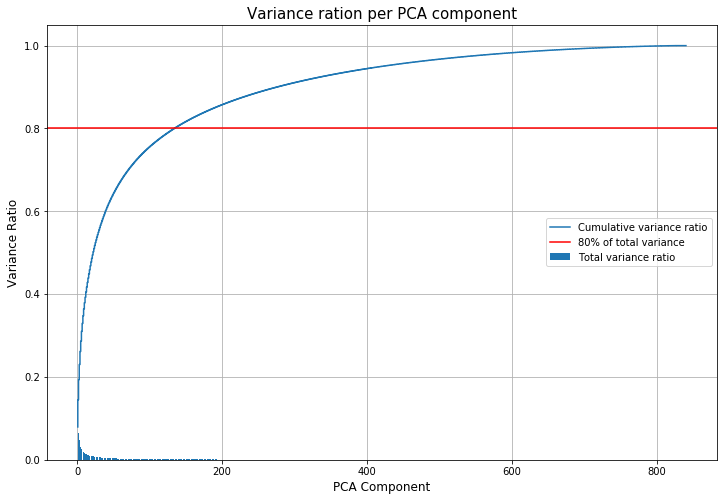

In [179]:
pca = PCA()
pca.fit(train_features)

var_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(12,8))
plt.bar(range(1,len(var_ratio)+1),var_ratio,align='center',label='Total variance ratio')
plt.step(range(1,len(var_ratio)+1),np.cumsum(var_ratio),label='Cumulative variance ratio')
plt.axhline(y=0.80,color='red',label='80% of total variance')
plt.xlabel('PCA Component',fontsize=12)
plt.ylabel('Variance Ratio',fontsize=12)
plt.legend(loc=7)
plt.title('Variance ration per PCA component',fontsize=15)
plt.grid()
plt.show()

## NLP: 50 Features / Images : 134 Features

In [86]:
# First test with 80% of total images features' variance

sum_pca = np.cumsum(pca.explained_variance_ratio_)
for counter, value in enumerate(sum_pca):
    if value > 0.80:
        train_image = pca.transform(train_features)[:,:counter]
        break
    
print('nombre de features : {}, variance : {}'.format(counter,np.cumsum(pca.explained_variance_ratio_)[counter]))

nombre de features : 134, variance : 0.8004184365272522


In [87]:
train_image.shape


(840, 134)

In [88]:
train_image=pd.DataFrame(train_image)
train_image

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,-17.441481,-4.477911,23.928919,-5.526152,20.576797,-7.359606,23.040775,4.716522,-6.385983,-4.520740,...,-5.974873,6.223502,3.823809,-1.615122,5.924343,3.034345,6.362925,2.651534,1.661792,4.049797
1,-7.014950,13.979825,3.460128,1.838652,-10.930029,-5.713898,-8.580553,7.992815,-3.078202,0.636141,...,-3.526057,-2.757658,-3.565629,1.985861,-1.993783,-2.008104,-0.291028,-0.769856,1.860073,-0.392710
2,32.853058,-19.350445,-1.310220,-2.256743,-0.139957,-8.298736,2.489278,29.146191,-12.095439,-19.960386,...,-0.482427,-0.988482,-0.331058,-1.199553,-3.842477,1.106775,-2.689654,0.435751,-0.280281,-1.589195
3,-3.778282,13.609964,6.000769,6.958665,-11.673911,-21.793015,-17.795557,16.584501,12.838873,-1.205885,...,-7.178275,-0.693058,3.407867,1.006028,0.597164,6.755764,6.527967,2.000742,-2.893809,-6.591711
4,-11.223529,26.020967,2.550260,2.890474,31.025997,3.910383,-25.872906,12.608855,-3.631950,1.779122,...,-4.968182,-6.765248,2.741911,1.144118,-1.054733,-7.808587,-0.286104,-2.097956,-4.855022,2.574835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3.202055,15.443976,0.437378,-7.197649,-13.319707,-4.333040,-3.467655,-1.818486,-2.247869,4.066176,...,-0.642862,-1.217699,0.505735,-4.566767,0.807963,-1.426889,-1.532812,0.051854,2.401728,-0.675857
836,17.914404,-8.412650,49.591316,1.944549,-3.801484,22.019442,1.881559,-14.158109,8.301407,12.203743,...,2.638227,0.855888,-3.373981,-0.052925,-3.716241,1.802472,-0.572517,-0.761228,-1.700655,-0.695889
837,35.990814,-18.601625,9.479114,0.982806,-0.491799,6.381379,4.162557,-12.329303,-19.827675,10.778639,...,-5.711419,-3.994902,-2.098141,2.808648,-0.069034,3.593142,-1.661797,-1.017001,-3.928392,-1.650489
838,-17.358038,-0.057863,34.227737,-3.459396,31.386230,-28.275688,36.388073,-10.532471,4.993850,-9.859474,...,0.440931,4.488222,-0.052477,-10.369410,-8.383262,-1.497412,-1.822687,1.712091,-1.654582,-6.722126


In [89]:
test_image = pca.transform(test_features)[:,:counter]
test_image=pd.DataFrame(test_image)
test_image

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,38.892448,-16.420443,-14.073622,7.888126,-6.918314,5.895080,-2.326989,-9.137445,-9.477871,4.517575,...,3.345944,-1.090030,-1.050242,0.220754,-1.599730,1.076358,4.024245,1.670628,-0.858453,-2.108139
1,-0.183756,1.953852,-1.416927,-2.289710,9.955443,-3.259661,-4.793593,-5.512660,4.381345,-10.249456,...,1.423398,0.827047,-3.543921,-2.674307,-0.433115,-1.692783,-1.218736,-0.082216,-3.448468,1.036735
2,-36.391930,-38.200794,-12.079514,-20.384319,-15.987847,5.386689,-15.684905,-7.692421,-14.397359,14.369420,...,0.019677,-0.040464,-0.328454,1.960254,0.250888,2.556829,1.709753,-0.414604,-4.479237,-0.645928
3,-11.739093,11.242438,5.107385,-7.315073,28.833853,5.261893,-0.661325,-14.131239,0.727423,-21.011084,...,3.354877,-0.369762,2.518237,1.274844,4.956556,-0.738100,-4.006792,1.818633,-2.598408,1.200770
4,1.026384,46.502960,-2.011960,-23.643923,-31.551924,-5.787818,-8.415222,-13.579081,-9.867542,7.971688,...,1.030408,-0.632189,-1.288298,-4.127470,-0.592174,-2.664597,0.019137,-2.350006,-1.083108,2.285676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,73.489891,-25.273777,-29.155304,-20.113762,-0.246978,2.205383,6.326062,3.845747,-26.051760,2.376628,...,3.672982,-0.072963,-0.562784,-1.817677,-1.957714,3.782114,-0.735686,2.484261,-0.939926,4.265140
206,-0.280230,-1.639966,5.276127,16.399057,9.398470,-3.548038,-0.622947,-8.342478,5.901409,-14.255005,...,-1.546377,2.865406,0.777790,-2.084355,4.807411,-0.866826,-0.446235,0.339881,-0.366663,1.175443
207,-7.606259,-7.287921,-33.271366,43.163441,-5.875434,8.314231,3.536325,-9.220145,-11.445587,-0.346696,...,-1.728938,-1.286568,-2.837953,1.426349,-0.743932,1.563399,0.938458,5.091089,0.724418,1.154604
208,-4.927763,-4.244732,2.988520,13.846685,-17.496595,-2.402324,-3.055938,29.108223,15.139381,5.503438,...,1.836946,-0.332132,-2.943218,0.636740,1.408423,0.382688,3.788971,-2.345976,1.095188,-0.357788


### Merge feature images + NLP 

In [90]:
# Rename nlp features so as to be able to track them  

overview_train_dbow

new_col=list(range(50))
for i in range(overview_train_dbow.shape[1]):
    new_col[i]='nlp_'+str(i)
overview_train_dbow.columns=new_col
overview_test_dbow.columns=new_col
overview_train_dbow.head()


,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,...,nlp_40,nlp_41,nlp_42,nlp_43,nlp_44,nlp_45,nlp_46,nlp_47,nlp_48,nlp_49
0,0.002796,-0.188044,-0.567719,-0.071493,0.666617,0.966752,-0.731078,0.822494,1.391004,0.322278,...,0.487524,0.341624,0.720870,-0.937375,-0.373862,-0.010457,-0.508383,-0.060687,0.751093,-1.039242
1,0.880054,-1.259924,0.459411,-1.504316,-0.104630,0.516509,-1.128126,-0.176354,1.103158,0.944922,...,0.689598,0.367324,-0.394470,0.033491,-0.721990,-0.106835,0.271732,-0.476566,0.754828,-0.953028
2,-0.387786,-0.564510,0.029245,-1.033474,0.127880,0.104265,-0.922162,-0.332385,1.638565,-0.834022,...,0.509405,0.787843,-0.554423,0.113493,-0.029495,-0.325589,-0.997866,0.201133,0.048091,-0.479652
3,-0.673602,0.222283,-0.433962,-1.272820,-0.620479,0.434242,-0.249711,0.366384,0.757183,0.566107,...,-0.125835,0.270678,0.086583,0.006057,0.135755,0.535886,-0.138483,-0.251850,-0.298492,-0.465757
4,0.632855,0.155662,0.046950,-0.505970,-0.188254,0.172480,0.320921,-0.026438,0.723017,-0.116071,...,-0.213867,0.775754,-0.000371,-0.337210,-0.042922,-0.256362,0.119364,-0.064108,0.139005,-0.612635


In [91]:
overview_train_dbow

,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,...,nlp_40,nlp_41,nlp_42,nlp_43,nlp_44,nlp_45,nlp_46,nlp_47,nlp_48,nlp_49
0,0.002796,-0.188044,-0.567719,-0.071493,0.666617,0.966752,-0.731078,0.822494,1.391004,0.322278,...,0.487524,0.341624,0.720870,-0.937375,-0.373862,-0.010457,-0.508383,-0.060687,0.751093,-1.039242
1,0.880054,-1.259924,0.459411,-1.504316,-0.104630,0.516509,-1.128126,-0.176354,1.103158,0.944922,...,0.689598,0.367324,-0.394470,0.033491,-0.721990,-0.106835,0.271732,-0.476566,0.754828,-0.953028
2,-0.387786,-0.564510,0.029245,-1.033474,0.127880,0.104265,-0.922162,-0.332385,1.638565,-0.834022,...,0.509405,0.787843,-0.554423,0.113493,-0.029495,-0.325589,-0.997866,0.201133,0.048091,-0.479652
3,-0.673602,0.222283,-0.433962,-1.272820,-0.620479,0.434242,-0.249711,0.366384,0.757183,0.566107,...,-0.125835,0.270678,0.086583,0.006057,0.135755,0.535886,-0.138483,-0.251850,-0.298492,-0.465757
4,0.632855,0.155662,0.046950,-0.505970,-0.188254,0.172480,0.320921,-0.026438,0.723017,-0.116071,...,-0.213867,0.775754,-0.000371,-0.337210,-0.042922,-0.256362,0.119364,-0.064108,0.139005,-0.612635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.561226,-0.077810,0.187794,-1.148844,-0.472647,0.083894,-0.027233,-0.186288,0.427130,-0.144700,...,0.480515,-0.220223,-0.231504,0.230873,-0.167408,0.099592,0.085391,-0.064389,-0.306956,-0.874998
836,0.020024,-0.019141,-0.314496,0.026750,0.530305,0.559453,-0.566314,0.314213,0.642201,-0.082581,...,-0.244237,0.329187,0.049883,-0.493154,0.751233,0.884403,-0.318484,0.083443,-0.326725,-0.528361
837,-0.893288,0.379309,0.354338,-1.140602,0.157312,-0.147452,-0.565854,0.044478,0.469737,-0.337159,...,0.229456,0.653360,-0.697289,-0.263445,0.762220,0.101540,-0.191102,0.388113,0.070141,-0.374599
838,-0.051664,0.576793,-0.350520,0.168970,0.530584,0.539769,-0.632582,0.682207,1.054437,-0.733379,...,0.303098,0.279479,0.192746,-0.771569,0.463823,0.709537,0.033819,-0.238959,-0.601240,-0.822748


In [92]:
# Merge NLP and image features

train_merged=train_image.merge(overview_train_dbow,how='left', left_index=True, right_index=True)
test_merged=test_image.merge(overview_test_dbow,how='left', left_index=True, right_index=True)
train_merged

,0,1,2,3,4,5,6,7,8,9,...,nlp_40,nlp_41,nlp_42,nlp_43,nlp_44,nlp_45,nlp_46,nlp_47,nlp_48,nlp_49
0,-17.441481,-4.477911,23.928919,-5.526152,20.576797,-7.359606,23.040775,4.716522,-6.385983,-4.520740,...,0.487524,0.341624,0.720870,-0.937375,-0.373862,-0.010457,-0.508383,-0.060687,0.751093,-1.039242
1,-7.014950,13.979825,3.460128,1.838652,-10.930029,-5.713898,-8.580553,7.992815,-3.078202,0.636141,...,0.689598,0.367324,-0.394470,0.033491,-0.721990,-0.106835,0.271732,-0.476566,0.754828,-0.953028
2,32.853058,-19.350445,-1.310220,-2.256743,-0.139957,-8.298736,2.489278,29.146191,-12.095439,-19.960386,...,0.509405,0.787843,-0.554423,0.113493,-0.029495,-0.325589,-0.997866,0.201133,0.048091,-0.479652
3,-3.778282,13.609964,6.000769,6.958665,-11.673911,-21.793015,-17.795557,16.584501,12.838873,-1.205885,...,-0.125835,0.270678,0.086583,0.006057,0.135755,0.535886,-0.138483,-0.251850,-0.298492,-0.465757
4,-11.223529,26.020967,2.550260,2.890474,31.025997,3.910383,-25.872906,12.608855,-3.631950,1.779122,...,-0.213867,0.775754,-0.000371,-0.337210,-0.042922,-0.256362,0.119364,-0.064108,0.139005,-0.612635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3.202055,15.443976,0.437378,-7.197649,-13.319707,-4.333040,-3.467655,-1.818486,-2.247869,4.066176,...,0.480515,-0.220223,-0.231504,0.230873,-0.167408,0.099592,0.085391,-0.064389,-0.306956,-0.874998
836,17.914404,-8.412650,49.591316,1.944549,-3.801484,22.019442,1.881559,-14.158109,8.301407,12.203743,...,-0.244237,0.329187,0.049883,-0.493154,0.751233,0.884403,-0.318484,0.083443,-0.326725,-0.528361
837,35.990814,-18.601625,9.479114,0.982806,-0.491799,6.381379,4.162557,-12.329303,-19.827675,10.778639,...,0.229456,0.653360,-0.697289,-0.263445,0.762220,0.101540,-0.191102,0.388113,0.070141,-0.374599
838,-17.358038,-0.057863,34.227737,-3.459396,31.386230,-28.275688,36.388073,-10.532471,4.993850,-9.859474,...,0.303098,0.279479,0.192746,-0.771569,0.463823,0.709537,0.033819,-0.238959,-0.601240,-0.822748


In [93]:
std= StandardScaler()
train_merged_scaled = std.fit_transform(train_merged)
test_merged_scaled = std.transform(test_merged)

In [94]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

merged_grid = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

merged_grid.fit(train_merged_scaled, train.category)

merged_classifier =merged_grid.best_estimator_


print('Validation Score (accuracy): ',merged_grid.best_score_)

print('\nBest Params: ',merged_grid.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,merged_classifier.predict(test_merged_scaled)))

Validation Score (accuracy):  0.980952380952381

Best Params:  {'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}

Test Score (accuracy):  0.9380952380952381


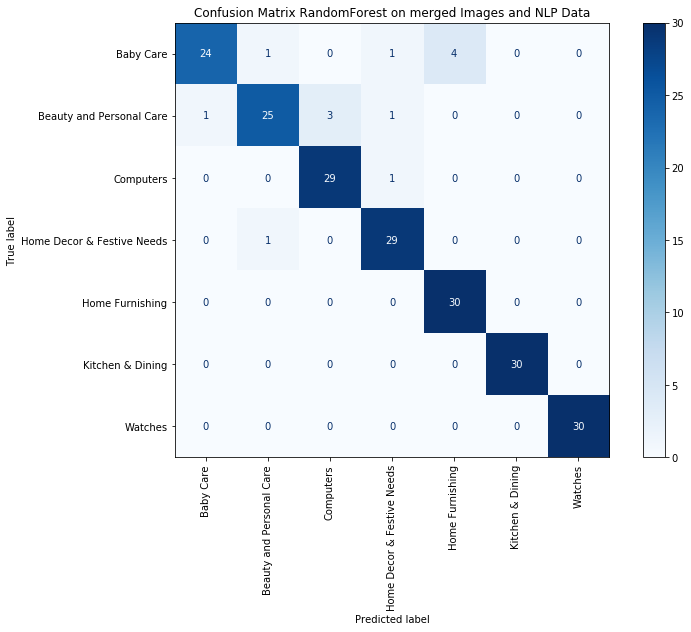

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(merged_classifier,
                      test_merged_scaled,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest on merged Images and NLP Data')
plt.show()  

We do not really improve the accuracy (the validation one is a bit lower than NLP alone)<Br> 
Let's observ feature importance to see which features are used

In [97]:
coef_features = merged_classifier.feature_importances_
study_feature = pd.concat((pd.DataFrame(train_merged.columns,columns=['Feature_name']),
                           pd.DataFrame(coef_features,columns=['Coef_feature'])),axis=1).sort_values(by='Coef_feature',ascending=False)
study_feature.head(50)

,Feature_name,Coef_feature
1,1,0.048518
0,0,0.039584
147,nlp_13,0.037804
3,3,0.031642
140,nlp_6,0.030465
169,nlp_35,0.028817
157,nlp_23,0.026933
141,nlp_7,0.026833
151,nlp_17,0.025324
181,nlp_47,0.024278


## NLP : 50 Features / Images : 276 Features

In [62]:
# Second test with 90% of variance 

sum_pca = np.cumsum(pca.explained_variance_ratio_)
for counter, value in enumerate(sum_pca):
    if value > 0.90:
        train_image = pca.transform(train_features)[:,:counter]
        break
    
print('nombre de features : {}, variance : {}'.format(counter,np.cumsum(pca.explained_variance_ratio_)[counter]))

nombre de features : 276, variance : 0.9003672003746033


In [63]:
train_image.shape


(840, 276)

In [64]:
train_image=pd.DataFrame(train_image)
train_image

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,275
0,-17.441481,-4.477911,23.928919,-5.526152,20.576797,-7.359606,23.040775,4.716522,-6.385983,-4.520740,...,4.589322,-1.060946,4.692010,2.296818,0.526646,-1.419508,-2.960960,-6.086294,-2.046577,3.222201
1,-7.014950,13.979825,3.460128,1.838652,-10.930029,-5.713898,-8.580553,7.992815,-3.078202,0.636141,...,1.514528,-0.142377,-1.154147,2.086679,4.993625,2.890411,0.976343,-1.611205,-1.550430,-1.006717
2,32.853058,-19.350445,-1.310220,-2.256743,-0.139957,-8.298736,2.489278,29.146191,-12.095439,-19.960386,...,-0.920204,-0.577385,1.598868,0.218153,1.083298,1.920603,3.840768,1.159695,5.397851,-1.881607
3,-3.778282,13.609964,6.000769,6.958665,-11.673911,-21.793015,-17.795557,16.584501,12.838873,-1.205885,...,1.573885,-5.261048,0.484905,0.877531,0.007502,0.270240,3.697781,1.585099,-2.816591,4.702884
4,-11.223529,26.020967,2.550260,2.890474,31.025997,3.910383,-25.872906,12.608855,-3.631950,1.779122,...,4.280481,-3.557068,3.474734,-0.229139,0.557722,-0.835489,-1.140877,1.836081,-1.385847,-0.928391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3.202055,15.443976,0.437378,-7.197649,-13.319707,-4.333040,-3.467655,-1.818486,-2.247869,4.066176,...,-0.696954,2.988542,-1.185639,1.942449,0.048316,1.125705,0.428147,0.869164,0.832156,-1.205490
836,17.914404,-8.412650,49.591316,1.944549,-3.801484,22.019442,1.881559,-14.158109,8.301407,12.203743,...,0.388519,-0.394796,-1.082305,0.021504,-1.379865,-0.326776,1.123315,0.439254,-0.195099,2.398871
837,35.990814,-18.601625,9.479114,0.982806,-0.491799,6.381379,4.162557,-12.329303,-19.827675,10.778639,...,0.151094,1.676020,-1.022302,1.102123,-1.380910,-1.154852,0.407108,1.004961,1.331486,2.950827
838,-17.358038,-0.057863,34.227737,-3.459396,31.386230,-28.275688,36.388073,-10.532471,4.993850,-9.859474,...,-0.077552,-2.239674,-3.348246,-0.237529,0.248811,0.984560,-1.514552,4.223487,-0.854385,0.232500


In [65]:
test_image = pca.transform(test_features)[:,:counter]
test_image=pd.DataFrame(test_image)
test_image

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,275
0,38.892448,-16.420443,-14.073622,7.888126,-6.918314,5.895080,-2.326989,-9.137445,-9.477871,4.517575,...,1.414159,0.450823,1.363008,2.736979,1.769060,-1.214146,-1.624712,1.391881,1.289089,-1.549782
1,-0.183756,1.953852,-1.416927,-2.289710,9.955443,-3.259661,-4.793593,-5.512660,4.381345,-10.249456,...,0.886505,-1.119057,1.920501,-0.300639,0.723430,-0.314607,-0.637496,-0.097074,-0.844301,-1.163334
2,-36.391930,-38.200794,-12.079514,-20.384319,-15.987847,5.386689,-15.684905,-7.692421,-14.397359,14.369420,...,-0.970046,0.495019,1.393262,-1.571640,-0.347705,-2.185732,1.014126,-1.854864,0.965968,0.704438
3,-11.739093,11.242438,5.107385,-7.315073,28.833853,5.261893,-0.661325,-14.131239,0.727423,-21.011084,...,1.986451,2.117196,-1.668576,-1.146093,1.807602,1.821832,1.405926,4.253487,1.377230,3.586978
4,1.026384,46.502960,-2.011960,-23.643923,-31.551924,-5.787818,-8.415222,-13.579081,-9.867542,7.971688,...,0.822936,2.572006,1.104614,-1.728234,0.330045,-0.130463,0.120180,0.527056,-0.976696,-0.541379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,73.489891,-25.273777,-29.155304,-20.113762,-0.246978,2.205383,6.326062,3.845747,-26.051760,2.376628,...,0.651240,-1.717099,0.717231,-0.522682,-1.531111,-0.097672,-0.160620,2.442664,-1.512610,0.534813
206,-0.280230,-1.639966,5.276127,16.399057,9.398470,-3.548038,-0.622947,-8.342478,5.901409,-14.255005,...,-0.147762,-0.247845,0.414951,0.450396,-1.515211,0.392536,1.415085,0.430771,0.688801,-1.950953
207,-7.606259,-7.287921,-33.271366,43.163441,-5.875434,8.314231,3.536325,-9.220145,-11.445587,-0.346696,...,0.601453,-1.409552,-0.880483,0.139108,2.354083,2.032023,-0.798113,-0.455157,0.803027,-0.249843
208,-4.927763,-4.244732,2.988520,13.846685,-17.496595,-2.402324,-3.055938,29.108223,15.139381,5.503438,...,-0.285507,-0.414056,-3.100744,-0.020051,0.263424,-0.275646,2.484966,0.329189,-2.683728,-0.536501


### Merge feature images + NLP 

In [81]:
overview_train_dbow

new_col=list(range(50))
for i in range(overview_train_dbow.shape[1]):
    new_col[i]='nlp_'+str(i)
overview_train_dbow.columns=new_col
overview_test_dbow.columns=new_col
overview_train_dbow.head()


,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,...,nlp_40,nlp_41,nlp_42,nlp_43,nlp_44,nlp_45,nlp_46,nlp_47,nlp_48,nlp_49
0,0.002796,-0.188044,-0.567719,-0.071493,0.666617,0.966752,-0.731078,0.822494,1.391004,0.322278,...,0.487524,0.341624,0.720870,-0.937375,-0.373862,-0.010457,-0.508383,-0.060687,0.751093,-1.039242
1,0.880054,-1.259924,0.459411,-1.504316,-0.104630,0.516509,-1.128126,-0.176354,1.103158,0.944922,...,0.689598,0.367324,-0.394470,0.033491,-0.721990,-0.106835,0.271732,-0.476566,0.754828,-0.953028
2,-0.387786,-0.564510,0.029245,-1.033474,0.127880,0.104265,-0.922162,-0.332385,1.638565,-0.834022,...,0.509405,0.787843,-0.554423,0.113493,-0.029495,-0.325589,-0.997866,0.201133,0.048091,-0.479652
3,-0.673602,0.222283,-0.433962,-1.272820,-0.620479,0.434242,-0.249711,0.366384,0.757183,0.566107,...,-0.125835,0.270678,0.086583,0.006057,0.135755,0.535886,-0.138483,-0.251850,-0.298492,-0.465757
4,0.632855,0.155662,0.046950,-0.505970,-0.188254,0.172480,0.320921,-0.026438,0.723017,-0.116071,...,-0.213867,0.775754,-0.000371,-0.337210,-0.042922,-0.256362,0.119364,-0.064108,0.139005,-0.612635


In [82]:
train_merged=train_image.merge(overview_train_dbow,how='left', left_index=True, right_index=True)
test_merged=test_image.merge(overview_test_dbow,how='left', left_index=True, right_index=True)
train_merged

,0,1,2,3,4,5,6,7,8,9,...,nlp_40,nlp_41,nlp_42,nlp_43,nlp_44,nlp_45,nlp_46,nlp_47,nlp_48,nlp_49
0,-17.441481,-4.477911,23.928919,-5.526152,20.576797,-7.359606,23.040775,4.716522,-6.385983,-4.520740,...,0.487524,0.341624,0.720870,-0.937375,-0.373862,-0.010457,-0.508383,-0.060687,0.751093,-1.039242
1,-7.014950,13.979825,3.460128,1.838652,-10.930029,-5.713898,-8.580553,7.992815,-3.078202,0.636141,...,0.689598,0.367324,-0.394470,0.033491,-0.721990,-0.106835,0.271732,-0.476566,0.754828,-0.953028
2,32.853058,-19.350445,-1.310220,-2.256743,-0.139957,-8.298736,2.489278,29.146191,-12.095439,-19.960386,...,0.509405,0.787843,-0.554423,0.113493,-0.029495,-0.325589,-0.997866,0.201133,0.048091,-0.479652
3,-3.778282,13.609964,6.000769,6.958665,-11.673911,-21.793015,-17.795557,16.584501,12.838873,-1.205885,...,-0.125835,0.270678,0.086583,0.006057,0.135755,0.535886,-0.138483,-0.251850,-0.298492,-0.465757
4,-11.223529,26.020967,2.550260,2.890474,31.025997,3.910383,-25.872906,12.608855,-3.631950,1.779122,...,-0.213867,0.775754,-0.000371,-0.337210,-0.042922,-0.256362,0.119364,-0.064108,0.139005,-0.612635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,3.202055,15.443976,0.437378,-7.197649,-13.319707,-4.333040,-3.467655,-1.818486,-2.247869,4.066176,...,0.480515,-0.220223,-0.231504,0.230873,-0.167408,0.099592,0.085391,-0.064389,-0.306956,-0.874998
836,17.914404,-8.412650,49.591316,1.944549,-3.801484,22.019442,1.881559,-14.158109,8.301407,12.203743,...,-0.244237,0.329187,0.049883,-0.493154,0.751233,0.884403,-0.318484,0.083443,-0.326725,-0.528361
837,35.990814,-18.601625,9.479114,0.982806,-0.491799,6.381379,4.162557,-12.329303,-19.827675,10.778639,...,0.229456,0.653360,-0.697289,-0.263445,0.762220,0.101540,-0.191102,0.388113,0.070141,-0.374599
838,-17.358038,-0.057863,34.227737,-3.459396,31.386230,-28.275688,36.388073,-10.532471,4.993850,-9.859474,...,0.303098,0.279479,0.192746,-0.771569,0.463823,0.709537,0.033819,-0.238959,-0.601240,-0.822748


In [84]:
std= StandardScaler()
train_merged_scaled = std.fit_transform(train_merged)
test_merged_scaled = std.transform(test_merged)

In [69]:
parameters = {"n_estimators": [100,150,200],  #Number of tree to build
              "max_depth": np.linspace(10, 110, num = 4),   # Max depth of the tree
              "min_samples_leaf": [1,3,5],#min amount of sample to have both left and right to a node
              "max_features":['auto', 'sqrt'] # additionnal source of random (max feature available 
                                                                     # when looking at feature for best split)
             } 

merged_grid = GridSearchCV(estimator = RandomForestClassifier(), 
                              param_grid = parameters,
                              scoring ='accuracy' ,
                              cv=5)

merged_grid.fit(train_merged_scaled, train.category)

merged_classifier =merged_grid.best_estimator_


print('Validation Score (accuracy): ',merged_grid.best_score_)

print('\nBest Params: ',merged_grid.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,merged_classifier.predict(test_merged_scaled)))

Validation Score (accuracy):  0.9773809523809524

Best Params:  {'max_depth': 43.333333333333336, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 150}

Test Score (accuracy):  0.9142857142857143


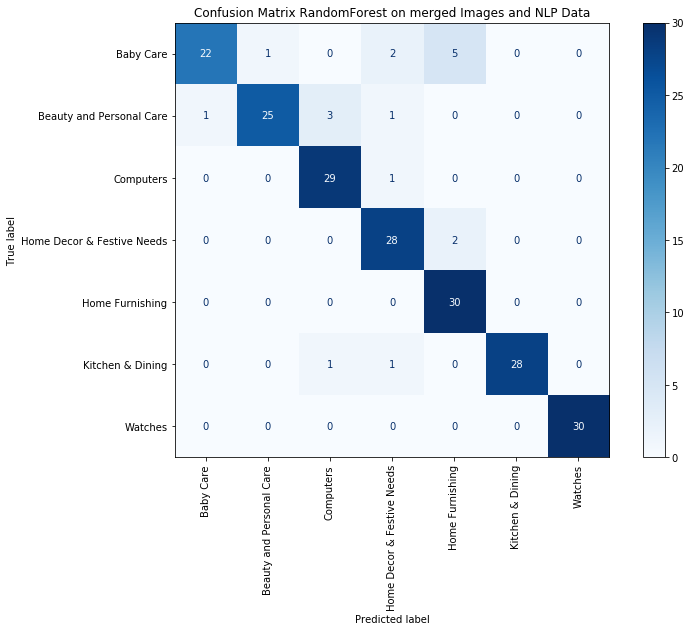

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(merged_classifier,
                      test_merged_scaled,
                      test.category,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix RandomForest on merged Images and NLP Data')
plt.show()  

In [98]:
coef_features = merged_classifier.feature_importances_
study_feature = pd.concat((pd.DataFrame(train_merged.columns,columns=['Feature_name']),
                           pd.DataFrame(coef_features,columns=['Coef_feature'])),axis=1).sort_values(by='Coef_feature',ascending=False)
study_feature.head(50)

,Feature_name,Coef_feature
1,1,0.048518
0,0,0.039584
147,nlp_13,0.037804
3,3,0.031642
140,nlp_6,0.030465
169,nlp_35,0.028817
157,nlp_23,0.026933
141,nlp_7,0.026833
151,nlp_17,0.025324
181,nlp_47,0.024278


# Stacking 

The stacking goal would be to use the predictions (probabilities) from NLP and Image classification and use them as features of a new classification model

In [131]:
col_nlp=list(range(7))
for i in range(7):
    col_nlp[i]='nlp_'+str(i)
col_image=list(range(7))
for i in range(7):
    col_image[i]='im_'+str(i)

In [120]:
test_keras_pred.shape

(210, 7)

In [124]:
train_keras = load_keras(train.image)
train_keras_pred = loaded_model.predict(train_keras)

In [136]:
test_pred_im = pd.DataFrame(test_keras_pred,columns=col_image)
train_pred_im = pd.DataFrame(train_keras_pred,columns=col_image)


In [116]:
test_nlp_out= doc2vec_model.predict_proba(overview_test_dbow)


In [122]:
train_nlp_out= doc2vec_model.predict_proba(overview_train_dbow)
train_nlp_out.shape

(840, 7)

In [123]:
train_nlp_out[0]

array([0.014     , 0.02970208, 0.020642  , 0.85692576, 0.03755556,
       0.03450794, 0.00666667])

In [134]:
test_pred_nlp = pd.DataFrame(test_nlp_out,columns=col_nlp)
train_pred_nlp = pd.DataFrame(train_nlp_out,columns=col_nlp)


In [139]:
train_pred_merged=train_pred_im.merge(train_pred_nlp,how='left', left_index=True, right_index=True)
test_pred_merged=test_pred_im.merge(test_pred_nlp,how='left', left_index=True, right_index=True)

Unfortunately we did not spare a last dataset to train the stacking model, so we will try to :
    *  train it with the previous train dataset (which will probably give relatively bad results due to the "too" good level of prediction on the train set)
    *  train it with a split of the test dataset (the results will not be something that we can compare with other results as, it will not be the same test set anymore)

## Train stacking with previous train dataset

In [142]:
parameters = {"n_estimators": [50,100,150], 
              "learning_rate": [0.05,0.1],  #Step for gradient descent
              "max_depth": np.linspace(5, 110, num = 4),
              "min_samples_leaf": [1,3,5]
             } 


gbr_grid = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid = parameters,
                        scoring = 'accuracy',
                        cv=5)

gbr_grid.fit(train_pred_merged, train.category)

stacking = gbr_grid.best_estimator_
            
print('Validation Score (accuracy): ',gbr_grid.best_score_)

print('\nBest Params: ',gbr_grid.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(test.category,stacking.predict(test_pred_merged)))


Validation Score (accuracy):  1.0

Best Params:  {'learning_rate': 0.05, 'max_depth': 5.0, 'min_samples_leaf': 1, 'n_estimators': 50}

Test Score (accuracy):  0.861904761904762


## Train stacking with splitting the test dataset

In [146]:
test_pred_merged['category']=test.category 

In [147]:
# Split train_test with keeping the categories distribution) 
train_stack,test_stack = train_test_split(test_pred_merged,
                                          test_size=0.50,
                                          stratify=test_pred_merged.category)


In [148]:
train_stack.shape

(105, 15)

In [149]:
y_train_stack = train_stack.category
X_train_stack = train_stack.drop(columns='category')

In [152]:
y_test_stack = test_stack.category
X_test_stack = test_stack.drop(columns='category')

In [153]:
parameters = {"n_estimators": [50,100,150], 
              "learning_rate": [0.05,0.1],  #Step for gradient descent
              "max_depth": np.linspace(5, 110, num = 4),
              "min_samples_leaf": [1,3,5]
             } 


gbr_grid = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid = parameters,
                        scoring = 'accuracy',
                        cv=5)

gbr_grid.fit(X_train_stack, y_train_stack)

stacking = gbr_grid.best_estimator_
            
print('Validation Score (accuracy): ',gbr_grid.best_score_)

print('\nBest Params: ',gbr_grid.best_params_)

print('\nTest Score (accuracy): ',accuracy_score(y_test_stack,stacking.predict(X_test_stack)))

Validation Score (accuracy):  0.9523809523809523

Best Params:  {'learning_rate': 0.1, 'max_depth': 5.0, 'min_samples_leaf': 5, 'n_estimators': 150}

Test Score (accuracy):  0.8666666666666667


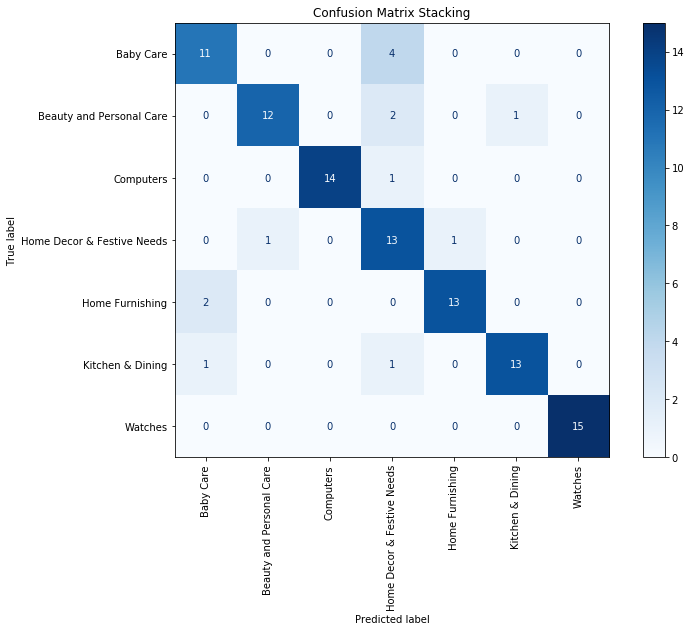

In [176]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_confusion_matrix(stacking,
                      X_test_stack,
                      y_test_stack,
                      ax=ax,
                      xticks_rotation=90,
                      cmap='Blues') 

ax.set_title('Confusion Matrix Stacking')
plt.show() 

In the end the results aren't better than NLP alone, it would be interesting to have a bigger dataset (notably for the images part) to be able to have better performance on our image model and probably have more optimization options on this last section 